In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import boutdata

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

In [3]:
cs = {}
cs["master"] = xhermes.open_hermesdataset(datapath = r"/ssd_scratch/hcases/integrated-tests/neutral-mixed-master/BOUT.dmp.*.nc", info = False)
cs["neutadv"] = xhermes.open_hermesdataset(datapath = r"/ssd_scratch/hcases/integrated-tests/neutral-mixed-neutadv/BOUT.dmp.*.nc", info = False)
cs["noupwind"] = xhermes.open_hermesdataset(datapath = r"/ssd_scratch/hcases/integrated-tests/neutral-mixed-no_perp_upwind/BOUT.dmp.*.nc", info = False)

/ssd_scratch/scripts/xBOUT/xbout/geometries.py:225: UserWarning: Size of toroidal domain as calculated from nz*dz (<xarray.DataArray 'dz' ()>
dask.array<sub, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Attributes:
    cell_location:  CELL_CENTRE
    direction_y:    Standard
    direction_z:    Average
    source:         Coordinates
    metadata:       {'BOUT_VERSION': 5.2, 'Bnorm': 1.0, 'Cs0': 97871.51425755...
    options:        None
    geometry:        is not the same as 2pi*(ZMAX - ZMIN) (6.283185307179586): using value from dz
  warn(
/ssd_scratch/scripts/xBOUT/xbout/geometries.py:225: UserWarning: Size of toroidal domain as calculated from nz*dz (<xarray.DataArray 'dz' ()>
dask.array<sub, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Attributes:
    cell_location:  CELL_CENTRE
    direction_y:    Standard
    direction_z:    Average
    source:         Coordinates
    metadata:       {'BOUT_VERSION': 5.2, 'Bnorm': 1.0, 'Cs0': 97871.51425755

In [ ]:
ds = cs["master"]

ds.data_vars

In [10]:
ds.dims

Frozen({'x': 10, 'y': 10, 'z': 10})

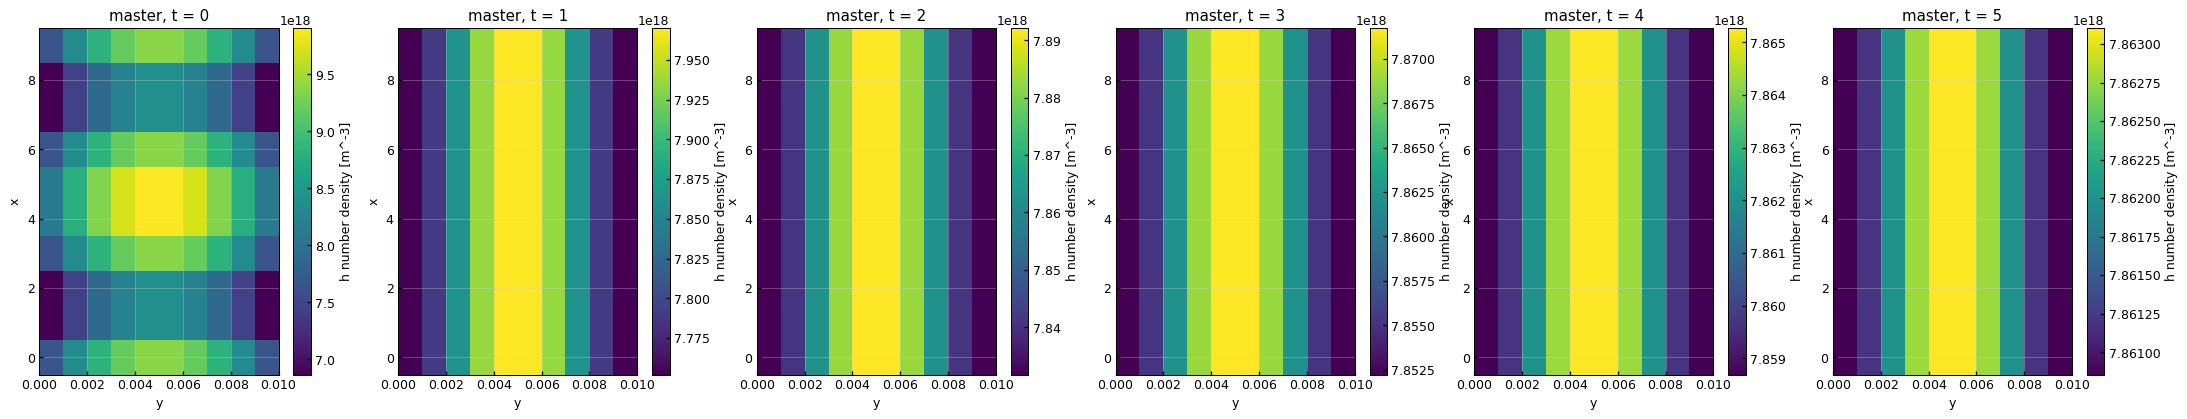

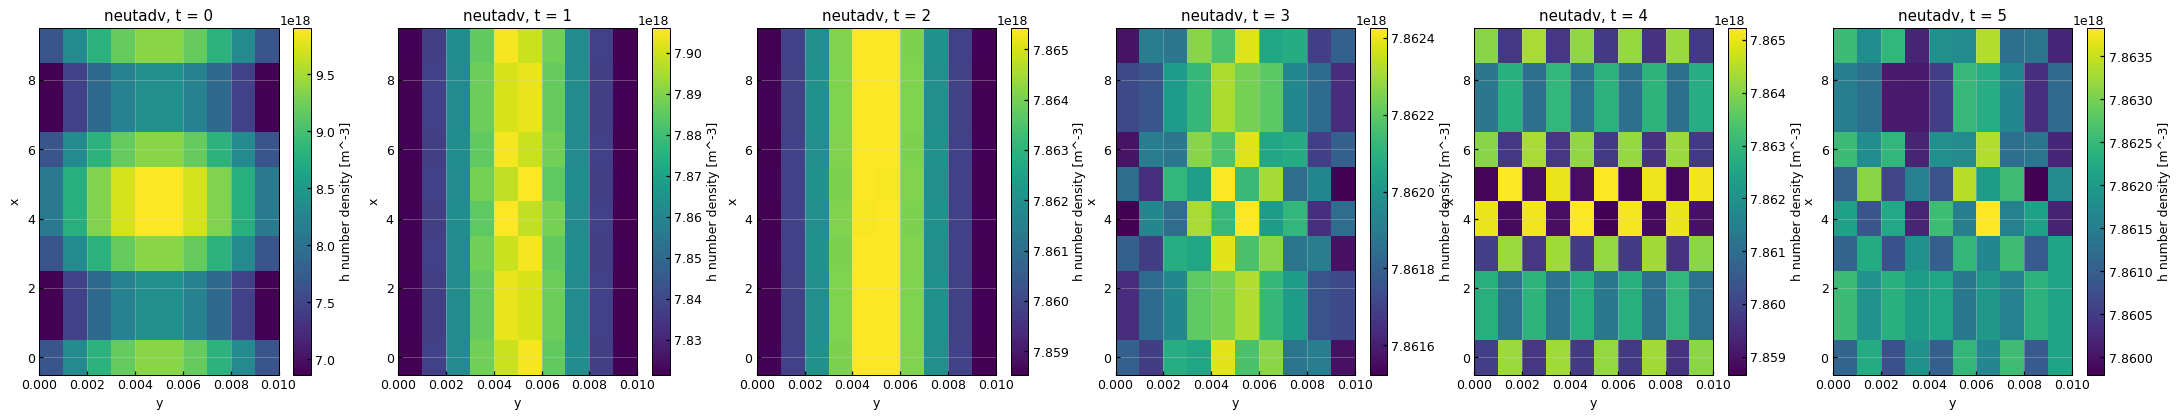

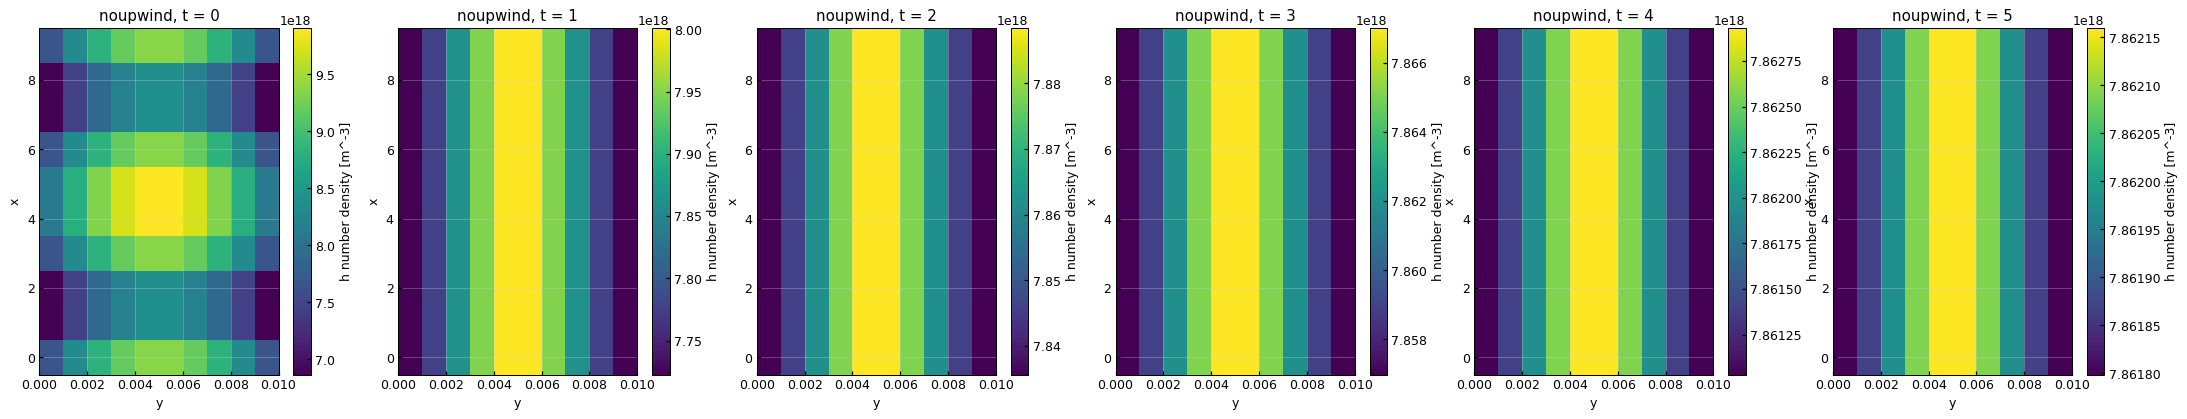

In [4]:
for name in cs:

    tlist = range(6)

    fig, axes = plt.subplots(1, len(tlist), figsize = (5*len(tlist), 5), dpi = 90)

    for i, t in enumerate(tlist):
        ds = cs[name].isel(t=t, z = 5)
        ds["Nh"].plot(ax = axes[i])

        axes[i].set_title(f"{name}, t = {t}")